/tmp/ipykernel_1921598/1035739374.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_games_data_clean["Year_of_Release"] = video_games_data_clean["Year_of_Release"].astype(int)
/tmp/ipykernel_1921598/1035739374.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  video_games_data

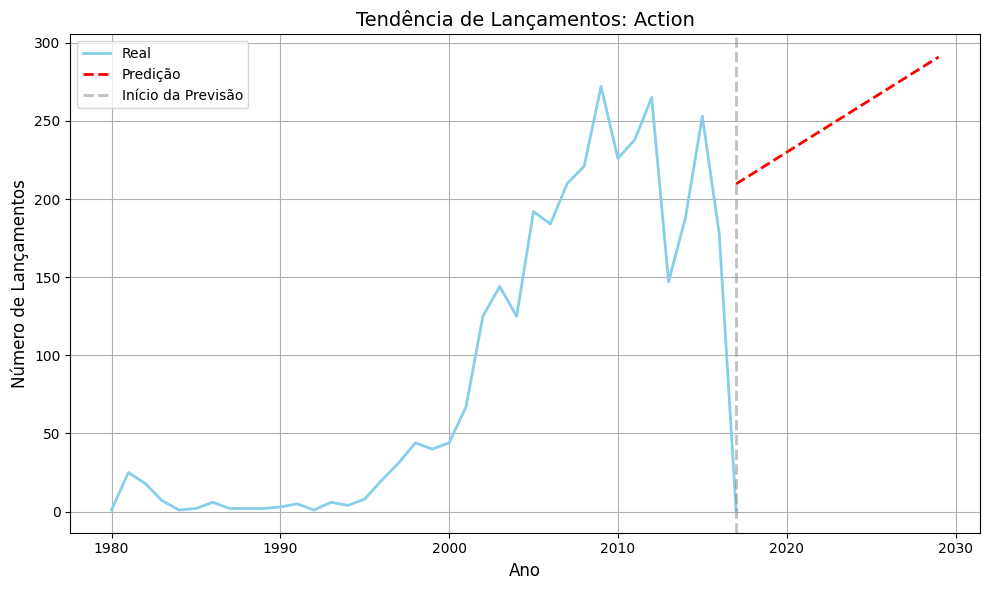

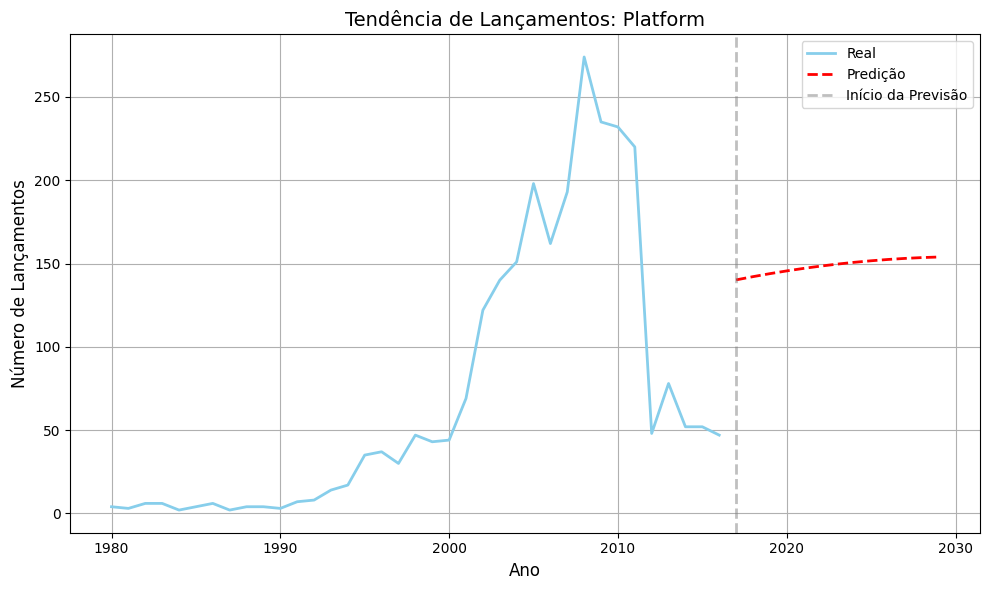

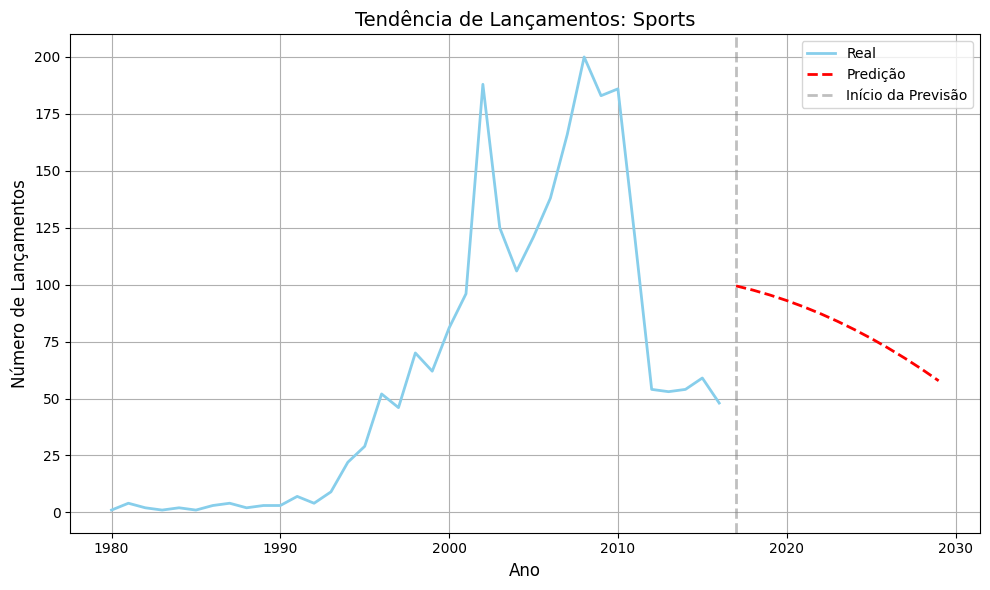

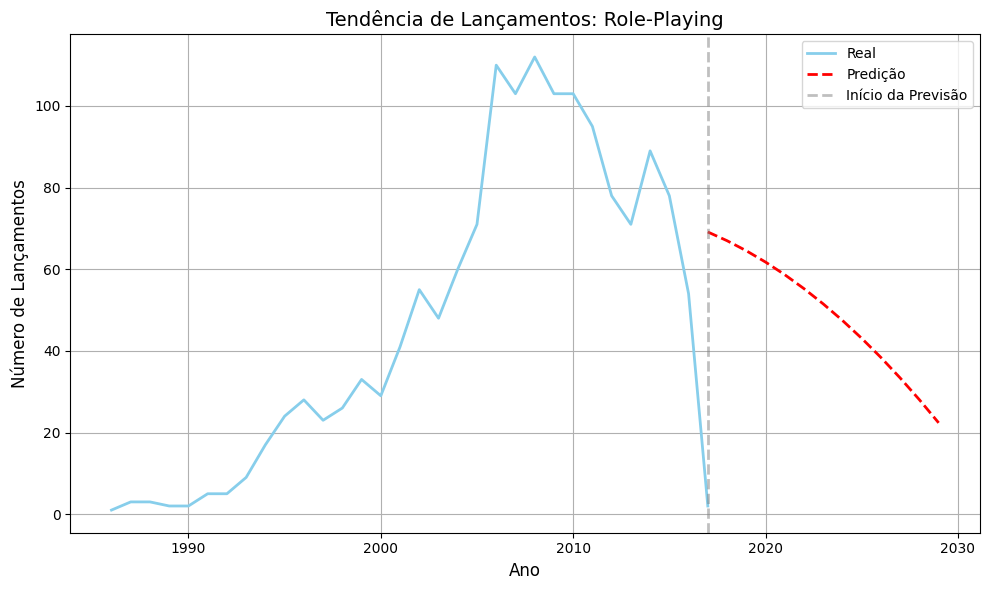

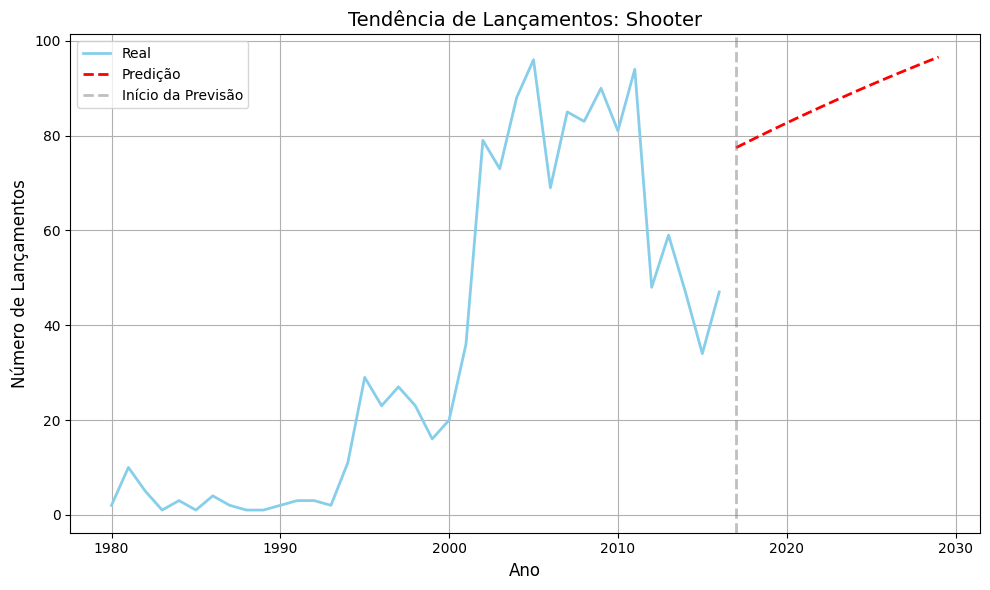

In [1]:

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

#carregar o dataset
# file_path = 'C:/Users/arthu/Downloads/Dataset/Video_Games_Sales_as_at_22_Dec_2016.csv'  #atualize o caminho conforme necessário
# video_games_data = pd.read_csv(file_path, encoding='ISO-8859-1')
video_games_data = pd.read_csv('dataset/video_games_2016.csv')

#preparação dos dados
video_games_data_clean = video_games_data.dropna(subset=["Year_of_Release", "Genre"])
video_games_data_clean["Year_of_Release"] = video_games_data_clean["Year_of_Release"].astype(int)

#saubstituir Misc por Platform pequena gambiarra kkkkkkkk
video_games_data_clean["Genre"].replace("Misc", "Platform", inplace=True)

#contar lançamentos por ano e gênero
release_trends_by_genre = video_games_data_clean.groupby(["Year_of_Release", "Genre"]).size().reset_index(name="Count")

#seleção dos 5 gêneros com mais lançamentos
top_genres = release_trends_by_genre.groupby("Genre")["Count"].sum().sort_values(ascending=False).head(5).index

#filtrar os dados para os 5 principais gêneros
filtered_data = release_trends_by_genre[release_trends_by_genre["Genre"].isin(top_genres)]

#função para prever tendências e visualizar os gráficos com regressão polinomial
def visualize_genre_trend(data, genre, year_range, degrees=[1, 2]):
    genre_data = data[data["Genre"] == genre]
    X = genre_data["Year_of_Release"].values.reshape(-1, 1)
    y = genre_data["Count"].values

    #divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_model = None
    best_r2 = float("-inf")  #inicializando o melhor R² com valor muito baixo
    best_poly = None

    #testar os diferentes graus para encontrar o melhor modelo
    for degree in degrees:
        #criando o modelo de regressão polinomial
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)

        model = LinearRegression()
        model.fit(X_poly, y_train)
        X_test_poly = poly.transform(X_test)
        y_pred = model.predict(X_test_poly)

        #calcular R²
        r2 = r2_score(y_test, y_pred)

        #verificar se o modelo atual é o melhor
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_poly = poly

    #exibir apenas o gráfico do melhor modelo (dos 5 generos)
    if best_model is not None and best_poly is not None:
        plt.figure(figsize=(10, 6))

        #plotar os dados reais como uma linha suave
        plt.plot(X.flatten(), y, color="skyblue", label="Real", linewidth=2)  #linha suavizada

        #transformar os anos futuros e fazer as predições
        future_years = np.array(year_range).reshape(-1, 1)
        future_years_poly = best_poly.transform(future_years)
        future_predictions = best_model.predict(future_years_poly)

        #plotar as predições com curvatura suave
        plt.plot(future_years, future_predictions, "r--", label="Predição", linewidth=2)

        #linha indicando onde começa a previsão
        plt.axvline(x=year_range[0], color='gray', linestyle='--', linewidth=2, alpha=0.5, label="Início da Previsão")

        #títulos e labels
        plt.title(f"Tendência de Lançamentos: {genre}", fontsize=14)
        plt.xlabel("Ano", fontsize=12)
        plt.ylabel("Número de Lançamentos", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#gerar gráficos
year_range = range(2017, 2030)
for genre in top_genres:
    visualize_genre_trend(filtered_data, genre, year_range, degrees=[1, 2])
